In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
import warnings
warnings.filterwarnings('ignore')

In [139]:
df = pd.read_csv('diabetes.csv')

# Exploratory Data Analysis

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [141]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [142]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [143]:
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [144]:
df.shape

(768, 9)

In [145]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']

  num_but_cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O'
              and dataframe[col].nunique() < cat_th ]

  cat_but_car_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O'
                      and dataframe[col].nunique() > car_th]

  cat_cols = [col for col in cat_cols if col not in cat_but_car_cols]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
  num_cols = [col for col in num_cols if col not in num_but_cat_cols]


  print(f'Observations: {dataframe.shape[0]}')
  print(f'Variables: {dataframe.shape[1]}')
  print(f'Categorical columns: {len(cat_cols)}')
  print(f'Numeric columns: {len(num_cols)}')
  print(f'Num_but_cat columns: {len(num_but_cat_cols)}')
  print(f'Cat_but_car columns: {len(cat_but_car_cols)}')

  return cat_cols, num_cols, cat_but_car_cols


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768
Variables: 9
Categorical columns: 0
Numeric columns: 8
Num_but_cat columns: 1
Cat_but_car columns: 0


According to grab_col_names function, we have 8 numerical columns. The column which is num_but_cat is outcomes which is our target variable so we do not have to evaluate it.

When we look at the data, we can see that even though isna function says there's no missing values in dataset, describe function says some null datas may be filled with zero. Because a result of a blood that such as glucose cannot be zero. Let's evaluate them

In [146]:
mistakenly_filled_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in mistakenly_filled_cols:
  df[col] = df[col].replace(0, np.nan)

In [147]:
df.isna().sum()

,0
Pregnancies,0
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Now I converted wrong 0 to null data. I will evaluate them later.

# Outliers

Outlier is the data whose tent is quite different than normal data. Especially in linear models, it affects the curve and model's performance. We can replace outlier with some average values or we can remove them.

In general we use IQR method to determine outliers. If a data is bigger/larger than 1.5 times of our third iqr value which represents the 75% point order of data is said to be outlier.

In [148]:
def outlier_detector(dataframe, third=0.9, first=0.1):
    outliers_info = {}

    for col in dataframe.columns:
        if dataframe[col].dtype in ['float64', 'int64']:
            q3 = dataframe[col].quantile(third)
            q1 = dataframe[col].quantile(first)
            iqr = q3 - q1
            low = q1 - 1.5 * iqr
            up = q3 + 1.5 * iqr

            outliers = dataframe[(dataframe[col] > up) | (dataframe[col] < low)]
            outliers_count = len(outliers)

            if outliers_count > 0:
                outliers_info[col] = outliers_count

    return outliers_info

outliers_in_columns = outlier_detector(df)
print(outliers_in_columns)


{'SkinThickness': 1, 'Insulin': 3, 'DiabetesPedigreeFunction': 4}


After we look at describe table again, these outliers are clear at the max part. That's why we can remove these outliers.

In [149]:
def remove_outlier(dataframe, third = 0.9, first = 0.1):
  for col in dataframe.columns:
    if dataframe[col].dtype in ['float64', 'int64']:
      q3 = dataframe[col].quantile(third)
      q1 = dataframe[col].quantile(first)
      iqr = q3 - q1
      low = q1 - 1.5 * iqr
      up = q3 + 1.5 * iqr

      dataframe = dataframe[(dataframe[col] >= low) & (dataframe[col] <= up)]

  return dataframe

df = remove_outlier(df)

# Missing Values

In [150]:
def missing_values_table(dataframe, na_name=False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_cols].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end='\n')

    if na_name:
        return na_cols


missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


As it is clear from the missing values table, some null values has a big ratio on that column. We can delete or replace this missing values. Deleting data in small dataset such as this one may be causes some problems so I prefer replacing.

In [151]:
for col in num_cols:
  df[col] = df[col].fillna(df[col].median())

Now I filled the missing values with the median

# Feature Extraction

In [152]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1


I created a new column named difference which represent the difference between outcome(is she diabetes or not) and her diabetes expectation function result

In [153]:
df['Difference'] = df['Outcome'] - df['DiabetesPedigreeFunction']

In [154]:
compare_table = df[['Difference', 'Outcome']]

In [155]:
compare_table = compare_table.sort_values(by = 'Difference', ascending = False).reset_index()

In [156]:
compare_table

,index,Difference,Outcome
0,328,0.873,1
1,695,0.872,1
2,199,0.850,1
3,88,0.847,1
4,8,0.842,1
...,...,...,...
381,534,-1.251,0
382,383,-1.268,0
383,147,-1.400,0
384,395,-1.600,0


My new variable 'difference' has a linear relationship between outcome which is our target variable. Thus it can be a good new feature

# Data Visulation

In [157]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Difference
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,-0.167
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1,0.752
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1,0.842
14,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1,0.413
16,0,118.0,84.0,47.0,230.0,45.8,0.551,31,1,0.449


- Glucose & BMI

In [158]:
plt.style.use('ggplot')

<Axes: xlabel='BMI', ylabel='Glucose'>

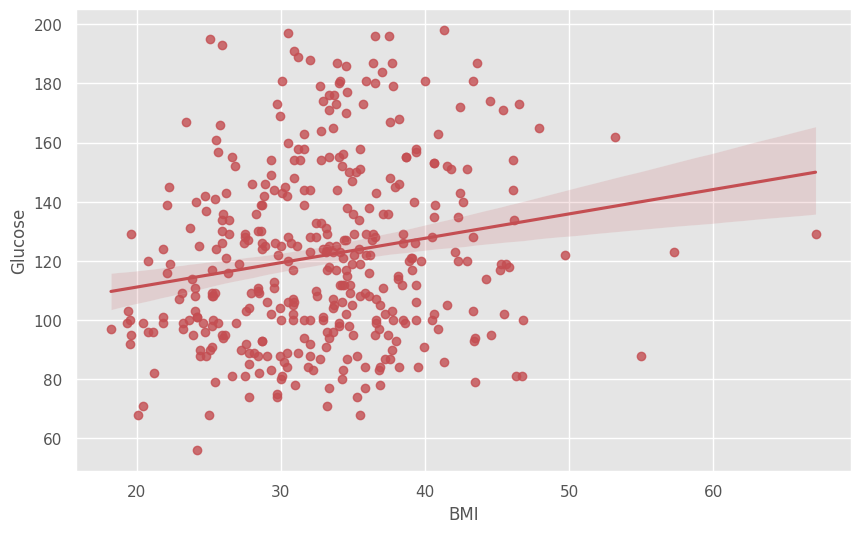

In [159]:
plt.figure(figsize = (10, 6))
sns.regplot(data = df, x = 'BMI', y = 'Glucose', color = 'r')

The graph says there's a linear relationship between BMI and glucose in blood

- Glucose & Blood Pressure

<Axes: xlabel='Glucose', ylabel='BloodPressure'>

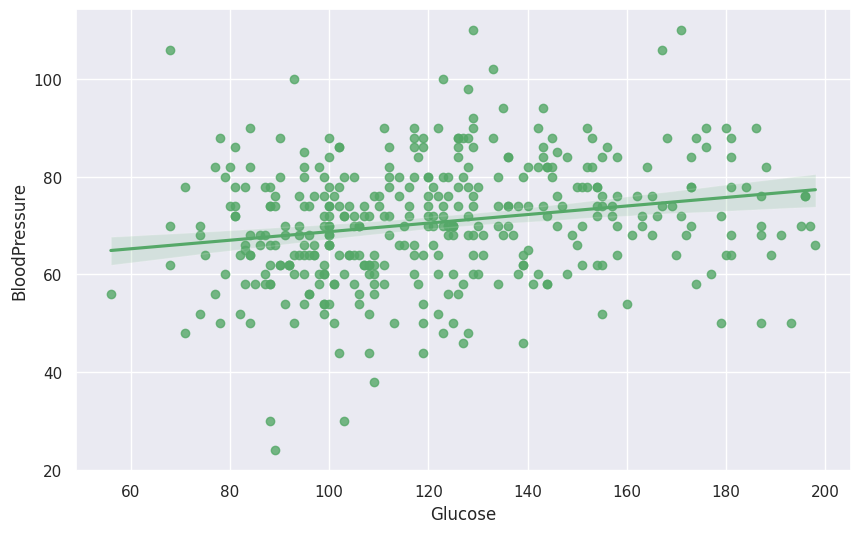

In [183]:
plt.figure(figsize = (10, 6))
sns.regplot(data = df, x = 'Glucose', y = 'BloodPressure', color = 'g')

Because of the low slope, we cannot say that there's an exact relationship betwween glucose and blood pressure

- Pregnancy & SkinThickness

Firstly let's cut pregnancy variable due to it has lots of unique value

In [161]:
df['Binned Pregnancy'] = pd.qcut(df['Pregnancies'], q = 4)

<Axes: xlabel='Binned Pregnancy', ylabel='SkinThickness'>

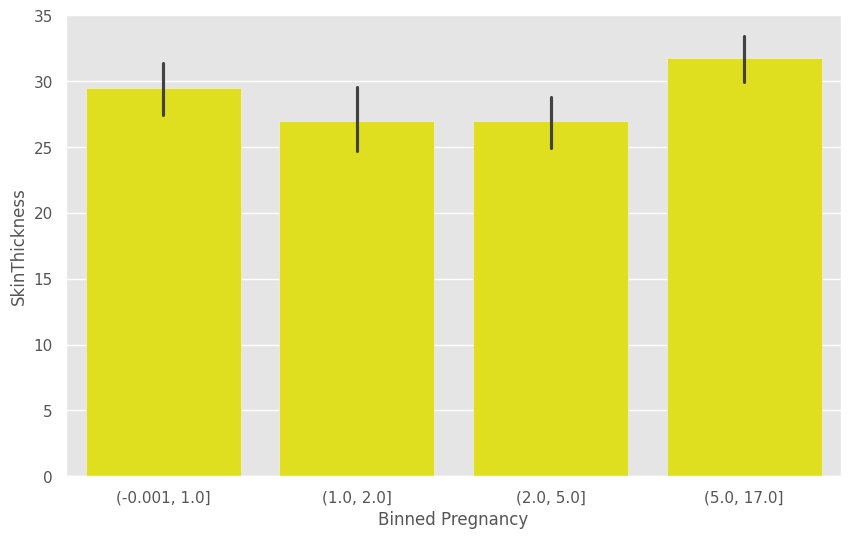

In [163]:
plt.figure(figsize = (10, 6))
sns.barplot(data = df, x = 'Binned Pregnancy', y = 'SkinThickness', color = 'yellow')

After we visualized we can drop the binned pregnancy column

In [164]:
df = df.drop('Binned Pregnancy', axis = 1)

# Correlation Analysis

In order to research the relationships of variable in dataset we use correlation table. Correlation coefficent has values between -1 and +1. 1 coefficent means there is an exact linear relationship between these two variable then -1 coefficent means there is an inverse linear relationship between these two variables.

If two variables have correlation coefficent more than 0.9, one of them must be removed because it means that they are almost same data.

In [165]:
numeric_columns = df.select_dtypes(include=np.number)
correlation = numeric_columns.corr()

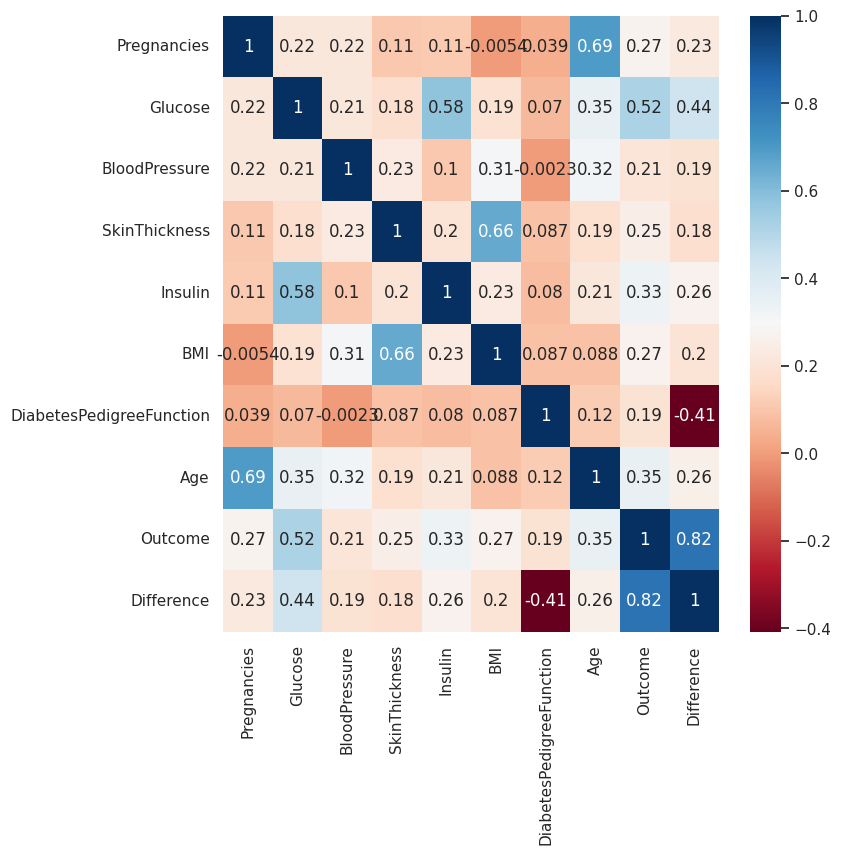

In [166]:
sns.set(rc={'figure.figsize': (8, 8)})
sns.heatmap(correlation, cmap="RdBu", annot=True)
plt.show()

Difference variable and outcome which is our target variable have 0.82 correlation coefficent. Difference is the feature I extracted later so we can remove it.

In [175]:
df = df.drop('Difference', axis = 1)

# Model Selection

We are gonna predict the patient has diabetes or not. Consequently this is a classification problem. Let's include required libraries

In [176]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [177]:
df.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
6,3,78.0,50.0,32.0,88.0,31.0,0.248,26,1
8,2,197.0,70.0,45.0,543.0,30.5,0.158,53,1


In [178]:
y = df['Outcome']
x = df.drop('Outcome', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, train_size = 0.8)

In [179]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        53
           1       0.77      0.40      0.53        25

    accuracy                           0.77        78
   macro avg       0.77      0.67      0.69        78
weighted avg       0.77      0.77      0.74        78



In [180]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        53
           1       0.73      0.44      0.55        25

    accuracy                           0.77        78
   macro avg       0.76      0.68      0.70        78
weighted avg       0.76      0.77      0.75        78



In [181]:
xg = XGBClassifier()
xg.fit(x_train, y_train)
xg_pred = xg.predict(x_test)
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.75      0.87      0.81        53
           1       0.59      0.40      0.48        25

    accuracy                           0.72        78
   macro avg       0.67      0.63      0.64        78
weighted avg       0.70      0.72      0.70        78



According to this classification reports, Random Forest Classifier is s better model. We can heal the parameters in order to obtain better scores.

In [182]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

print("En iyi parametreler:", grid_search.best_params_)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 216 candidates, totalling 648 fits
En iyi parametreler: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Confusion Matrix:
 [[52  1]
 [14 11]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.98      0.87        53
           1       0.92      0.44      0.59        25

    accuracy                           0.81        78
   macro avg       0.85      0.71      0.73        78
weighted avg       0.83      0.81      0.78        78



After the hyperparameter optimization, we have 81% f1-score which is not bad